<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/densenet_%EC%B5%9C%EC%A0%81%EC%84%B1%EB%8A%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary packages

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.optimizers import Adam
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [51]:
from google.colab import drive
drive.mount('/content/gdrive')
dst_path = '/content/gdrive/My Drive/dataset_split_aug'
# 경로 지정
import os
os.chdir('/content/gdrive/My Drive/dataset_split_aug')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 이미지 노이즈

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(dst_path, 'train')
validation_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=64,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64,64),
                                                        batch_size=64,
                                                        class_mode='categorical')

Found 30748 images belonging to 33 classes.
Found 7989 images belonging to 33 classes.


### DenseNet 모델 구성

In [53]:
SIZE=64
N_ch=3

In [60]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(33,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.summary()
    return model

### 모델 실행

In [67]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, min_lr=1e-3)

MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/model_save/dense3/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_accuracy',verbose=1, save_best_only=True)
earlystop=EarlyStopping(patience=10)

my_callbacks = [earlystop,checkpoint,annealer]

In [68]:
model = build_densenet()
dense = model.fit_generator(train_generator,
                               steps_per_epoch=400,
                               epochs=50,
                               validation_data=validation_generator,
                               validation_steps=100,
                               callbacks=my_callbacks)

Epoch 1/50
400/400 [==============================] - 141s 352ms/step - loss: 3.2143 - accuracy: 0.2423 - val_loss: 1.7347 - val_accuracy: 0.4989

Epoch 00001: val_accuracy improved from -inf to 0.49891, saving model to /content/gdrive/My Drive/model_save/dense3/01-1.7347.hdf5
Epoch 2/50
400/400 [==============================] - 101s 252ms/step - loss: 1.3600 - accuracy: 0.6079 - val_loss: 0.4525 - val_accuracy: 0.7893

Epoch 00002: val_accuracy improved from 0.49891 to 0.78933, saving model to /content/gdrive/My Drive/model_save/dense3/02-0.4525.hdf5
Epoch 3/50
400/400 [==============================] - 101s 253ms/step - loss: 0.8130 - accuracy: 0.7542 - val_loss: 0.6656 - val_accuracy: 0.7236

Epoch 00003: val_accuracy did not improve from 0.78933
Epoch 4/50
400/400 [==============================] - 101s 253ms/step - loss: 0.5630 - accuracy: 0.8299 - val_loss: 0.5621 - val_accuracy: 0.8300

Epoch 00004: val_accuracy improved from 0.78933 to 0.83002, saving model to /content/gdrive/

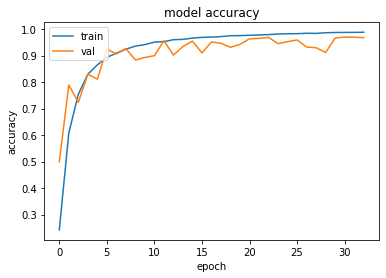

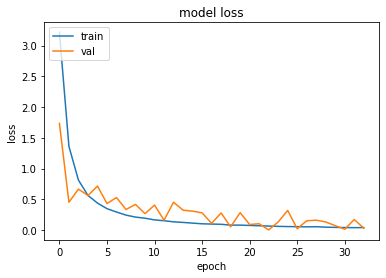

In [74]:
# accuracy plot 
plt.plot(dense.history['accuracy'])
plt.plot(dense.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(dense.history['loss'])
plt.plot(dense.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
model.save('/content/gdrive/My Drive/model_save/dense3/denseNet_3.h5')

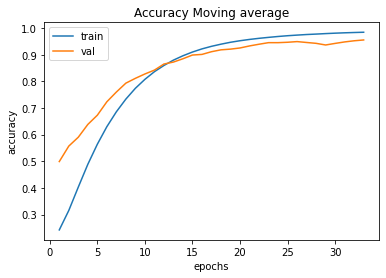

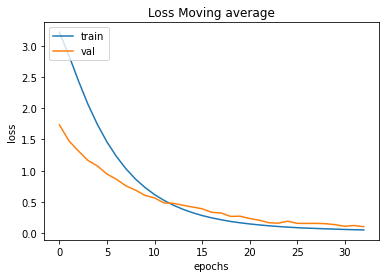

In [75]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(dense.history['accuracy'])
smooth_mae_history_val = smooth_curve(dense.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(smooth_curve(dense.history['loss']))
plt.plot(smooth_curve(dense.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()